# Data Analytics Challenge with Apache Spark

The objective of this challenge is to analyze using Apache Spark a data set containing the results of an experiment involving three algorithms.

The data set contains the results of three different algorithms (Model, CBC and NEWCBC) applied to instances characterized by 4 features (F1-F4). Each experiment was repeated 10 times (Rep, but notice that in 2 cases we only made one repetition) generating randomly the instances. It is important to note that the F3 feature is actually a range of values and at each repetition a new value is randomly generated within the range. For this reason, instances belonging to the same group can have distinct F3 values.

In addition:
1. *MODEL_OF* represents the value of the objective function obtained by the algorithm M
2. *MODEL_TIME* represents the time spent by the algorithm M
3. *CBC_OF* represents the value of the objective function obtained by the CBC algorithm
4. *CBC_TIME* represents the time spent by the CBC algorithm
5. *CBC_FC* represents the number of FC-type actions executed by the CBC algorithm
6. *CBC_PC* represents the number of PC-type actions executed by the CBC algorithm
7. *NEWCBC_OF* represents the value of the objective function obtained by the NEWCBC algorithm
8. *NEWCBC_TIME* represents the time spent by the NEWCBC algorithm
9. *NEWCBC_FC* represents the number of FC-type actions executed by the NEWCBC algorithm

------


We will analyze the data using *Koalas*, which is a Python library that implements the pandas DataFrame API on top of Apache Spark.

In [ ]:
!pip install koalas

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pyspark.sql import SparkSession
import pandas as pd
import databricks.koalas as ks
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()
%matplotlib inline

spark = SparkSession.builder \
        .master("local[*]") \
        .getOrCreate()

First of all, let's import the dataset files into a Koalas Dataframe. After that, we check if the schema of the Dataframe we just created is correct.

In [12]:
df = ks.read_excel('data/risultati_A_zaini_piccoli_9-11.xlsx')
df = df.append(ks.read_excel('data/risultati_B_piccole_45-55_1big_knapsack.xlsx'))
df = df.append(ks.read_excel('data/risultati_C_piccole_45-55.xlsx'))
df = df.append(ks.read_excel('data/risultati_D_con_piu_zaini.xlsx'))
df = df.append(ks.read_excel('data/risultati_E_con_piu_items.xlsx'))
df = df.append(ks.read_excel('data/risultati_F_zaini_piccoli_27-33.xlsx'))

In [4]:
df.spark.print_schema()

root
 |-- F1: long (nullable = false)
 |-- F2: long (nullable = false)
 |-- F3: long (nullable = false)
 |-- F4: string (nullable = false)
 |-- Rep: long (nullable = false)
 |-- MODEL_OF: long (nullable = false)
 |-- MODEL_OFUB: long (nullable = false)
 |-- MODEL_TIME: double (nullable = false)
 |-- CBC_OF: long (nullable = false)
 |-- CBC_TIME: double (nullable = false)
 |-- CBC_FC: long (nullable = false)
 |-- CBC_PC: long (nullable = false)
 |-- NEWCBC_OF: long (nullable = false)
 |-- NEWCBC_TIME: double (nullable = false)
 |-- NEWCBC_FC: long (nullable = false)



The schema of the Spark DataFrame managed by Koalas is correct, this means that the import phase was successful.

## Descriptive statistics
Let's first take a look at the structure of the dataset and some descriptive statistics.

In [5]:
df.describe().drop(columns="Rep")

,F1,F2,F3,MODEL_OF,MODEL_OFUB,MODEL_TIME,CBC_OF,CBC_TIME,CBC_FC,CBC_PC,NEWCBC_OF,NEWCBC_TIME,NEWCBC_FC
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.0
mean,6.775000,525.000000,9.567500,281.907500,284.177500,293.390935,281.862500,254.806183,0.082500,9.747500,281.810000,0.197912,0.0
std,3.868046,120.045939,2.218727,102.204959,105.388652,880.582345,102.186392,775.712798,0.454103,29.400164,102.086768,0.235036,0.0
min,3.000000,400.000000,6.000000,82.000000,82.000000,0.080000,82.000000,0.010000,0.000000,0.000000,82.000000,0.011000,0.0
25%,3.000000,400.000000,8.000000,206.000000,206.000000,1.020000,206.000000,0.090000,0.000000,0.000000,206.000000,0.047000,0.0
50%,5.000000,500.000000,9.000000,271.000000,272.000000,3.842000,271.000000,1.170000,0.000000,2.000000,271.000000,0.116000,0.0
75%,10.000000,600.000000,10.000000,338.000000,338.000000,20.808000,337.000000,20.569000,0.000000,6.000000,338.000000,0.260000,0.0
max,20.000000,1000.000000,19.000000,658.000000,658.000000,3600.000000,658.000000,3600.000000,5.000000,255.000000,658.000000,1.562000,0.0


Let's see the distribution of the features variables by plotting them in a box plot.

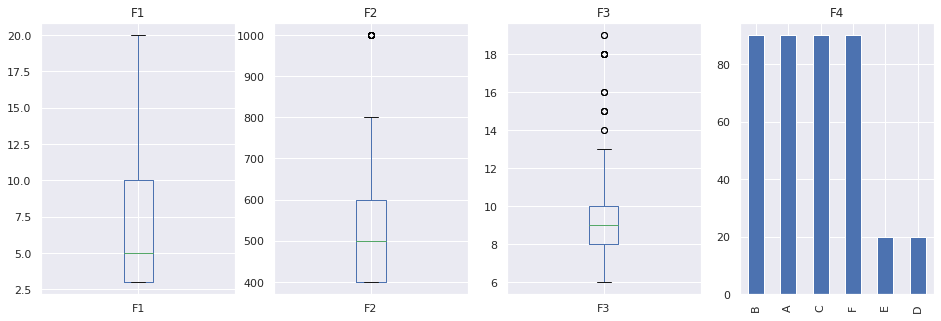

In [6]:
fig, axes = plt.subplots(ncols=4, figsize=(16, 5))
fig.set_facecolor('white')

df['F1'].plot.box(ax=plt.subplot(1, 4, 1))
plt.title("F1")
df['F2'].plot.box(ax=plt.subplot(1, 4, 2))
plt.title("F2")
df['F3'].plot.box(ax=plt.subplot(1, 4, 3))
plt.title("F3")
df['F4'].value_counts().plot.bar(ax=plt.subplot(1, 4, 4))
plt.title("F4")

plt.show()

We can also plot the distribution of TIME and OF for each algorithm on a histogram.

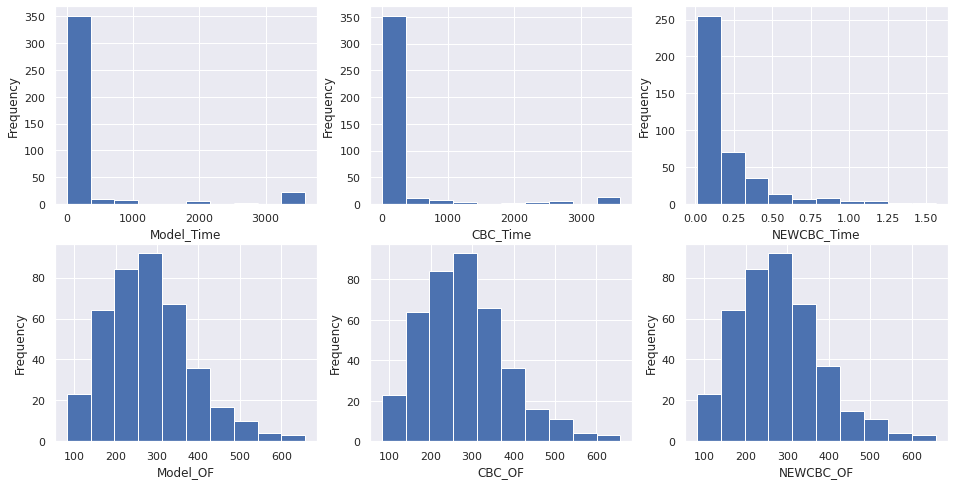

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

df['MODEL_TIME'].hist(ax=plt.subplot(2, 3, 1))
plt.xlabel('Model_Time')
plt.ylabel('Frequency')

df['MODEL_OF'].hist(ax=plt.subplot(2, 3, 4)) 
plt.xlabel('Model_OF')
plt.ylabel('Frequency')

df['CBC_TIME'].hist(ax=plt.subplot(2, 3, 2)) 
plt.xlabel('CBC_Time')
plt.ylabel('Frequency')

df['CBC_OF'].hist(ax=plt.subplot(2, 3, 5)) 
plt.xlabel('CBC_OF')
plt.ylabel('Frequency')

df['NEWCBC_TIME'].hist(ax=plt.subplot(2, 3, 3)) 
plt.xlabel('NEWCBC_Time')
plt.ylabel('Frequency')

df['NEWCBC_OF'].hist(ax=plt.subplot(2, 3, 6)) 
plt.xlabel('NEWCBC_OF')
plt.ylabel('Frequency')

plt.show()

The distributions of time and the objective function (OF) for each algorithm are clearly skewed to the right.

## Comparing algorithms effectiveness (OF value)

First of all, let's check if the distribution of MODEL_OF, CBC_OF and NEWCBC_OF is normal using Shapiro-Wilk test for normality. The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.

In [9]:
from scipy.stats import shapiro

print("MODEL_OF: ",shapiro(df['MODEL_OF'].to_numpy()))
print("CBC_OF:   ",shapiro(df['CBC_OF'].to_numpy()))
print("NEWCBC_OF:",shapiro(df['NEWCBC_OF'].to_numpy()))

MODEL_OF:  ShapiroResult(statistic=0.966986358165741, pvalue=7.543134472598467e-08)
CBC_OF:    ShapiroResult(statistic=0.9667572975158691, pvalue=6.89765613515192e-08)
NEWCBC_OF: ShapiroResult(statistic=0.9669656753540039, pvalue=7.48233759395589e-08)


The null hypothesis is rejected for each algorithm because the p-value is way less than 0.05 or 0.01. This means that the distribution of MODEL_OF, CBC_OF and NEWCBC_OF is not normal. Hence, we can't use t-tests or ANOVA but we must use a nonparametric test in order to compare the three samples.

The Kruskal-Wallis test is a nonparametric statistical procedure for comparing more than two samples that are independent, or not related. The parametric equivalent to this test is the one-way analysis of variance (ANOVA). When the Kruskal-Wallis test leads to significant results, then at least one of the samples is different from the other samples.

In [10]:
from scipy.stats import kruskal

kruskal(df['MODEL_OF'].to_numpy(), df['CBC_OF'].to_numpy(), df['NEWCBC_OF'].to_numpy())

KruskalResult(statistic=0.00013436269145136718, pvalue=0.9999328209108904)

We can't reject the null hypothesis that the population median of all of the algorithms are equal because we have a p-value of about 1, so we can say that the three groups have the same median. Thus, all 3 algorithms seem to have the same effectiveness.
## Comparing algorithms efficiency (TIME value)
As we can see in the histograms above the distribution of TIME values in each algorithm is clearly not normal. This means that we must again use a non parametric test to compare samples. We use the Kruskal-Wallis test again.

In [11]:
kruskal(df['MODEL_TIME'].to_numpy(), df['CBC_TIME'].to_numpy(), df['NEWCBC_TIME'].to_numpy())

KruskalResult(statistic=435.6336411937821, pvalue=2.531376529390946e-95)

The test result is significant, then at least one of the samples is different from the other samples. However, the test does not identify where the difference(s) occur. Moreover, it does not identify how many differences occur. To identify the particular differences between sample pairs we will use the Mann-Whitney test (a.k.a. Wilcoxon rank-sum test) in order to perform sample contrasts between individual sample sets. The null hypothesis of this test asserts that the medians of the two samples are identical. 

In [12]:
from scipy.stats import mannwhitneyu

print("MODEL_TIME - CBC_TIME:   ",mannwhitneyu(df['MODEL_TIME'].to_numpy(), df['CBC_TIME'].to_numpy()))
print("MODEL_TIME - NEWCBC_TIME:",mannwhitneyu(df['MODEL_TIME'].to_numpy(), df['NEWCBC_TIME'].to_numpy()))
print("CBC_TIME - NEWCBC_TIME:  ",mannwhitneyu(df['CBC_TIME'].to_numpy(), df['NEWCBC_TIME'].to_numpy()))

MODEL_TIME - CBC_TIME:    MannwhitneyuResult(statistic=60608.0, pvalue=1.4763561231062497e-09)
MODEL_TIME - NEWCBC_TIME: MannwhitneyuResult(statistic=7874.0, pvalue=3.043885928956426e-108)
CBC_TIME - NEWCBC_TIME:   MannwhitneyuResult(statistic=41702.0, pvalue=5.058484003020759e-32)


All the three tests make us reject the null hypothesis, this means that the medians of the three samples are all different. Then, we can compare the three algorithms' efficiency by just comparing their median.

In [13]:
print("MODEL_TIME median: ",df['MODEL_TIME'].median())
print("CBC_TIME median:   ",df['CBC_TIME'].median())
print("NEWCBC_TIME median:",df['NEWCBC_TIME'].median())

MODEL_TIME median:  3.842
CBC_TIME median:    1.17
NEWCBC_TIME median: 0.116


Since NEWCBC is the algorithm with the smallest median time, we can say that it's the most efficient algorithm.

## Studying the correlation between features and values

<AxesSubplot:>

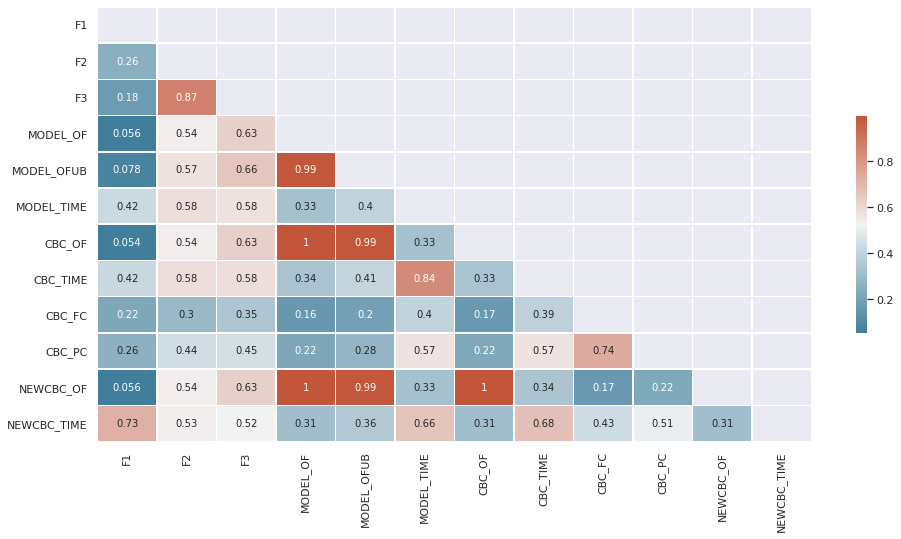

In [4]:
corr = df.corr().to_pandas().drop(["NEWCBC_FC", "Rep"]).drop(columns=["NEWCBC_FC", "Rep"])
f, ax = plt.subplots(figsize=(16, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

As we can see from the correlation matrix above, we notice that CBC_OF, NEWCBC_OF and MODEL_OF are perfectly correlated, and that the TIME values of the three algorithms are highly correlated as well.

We also see that F1 has a great impact (that is, it's highly correlated) on NEWCBC_TIME (the execution time of the NEWCBC algorithm), and that F3 seems moderately correlated with the values of OF for each algorithm.

F1 doesn't seem to be correlated with the other features, while F2 is highly correlated with the value of F3.

## Predicting Time and OF

First of all, we need to one-hot encode the F4 variable because it's a categorical variable.

In [13]:
f4_dummies = ks.get_dummies(df["F4"], prefix="F4")
df = ks.concat([df, f4_dummies], axis=1, sort=False)
df.head(5)

,F1,F2,F3,F4,Rep,MODEL_OF,MODEL_OFUB,MODEL_TIME,CBC_OF,CBC_TIME,CBC_FC,CBC_PC,NEWCBC_OF,NEWCBC_TIME,NEWCBC_FC,F4_A,F4_B,F4_C,F4_D,F4_E,F4_F
0,3,400,9,A,1,197,197,0.290,197,0.02,0,1,197,0.056,0,1,0,0,0,0,0
1,3,400,9,A,2,162,162,0.240,162,0.02,0,0,162,0.016,0,1,0,0,0,0,0
2,3,400,9,A,3,165,165,0.850,165,0.01,0,0,165,0.023,0,1,0,0,0,0,0
3,3,400,6,A,4,178,178,0.311,178,0.02,0,1,178,0.012,0,1,0,0,0,0,0
4,3,400,9,A,5,220,220,0.720,220,0.03,0,1,220,0.038,0,1,0,0,0,0,0


Then, we create a unique column containing the values of all the features to be used for the model.

In [39]:
from pyspark.ml.feature import VectorAssembler

features_list = ["F1", "F2", "F3", "F4_A", "F4_B", "F4_C", "F4_D", "F4_E"]
vectorAssembler = VectorAssembler(inputCols=features_list, outputCol="features")

After this, we can try to fit a Linear Regression model for the TIME variable.

In [50]:
from pyspark.ml.regression import LinearRegression

targets = ["MODEL_TIME", "CBC_TIME", "NEWCBC_TIME"]

for t in targets:
    ml_df = vectorAssembler.transform(df.to_spark()).select("features", t)
    time_lr = LinearRegression(featuresCol='features', labelCol=t)
    time_lr_model = time_lr.fit(ml_df)
    print(t, " RMSE:",time_lr_model.summary.rootMeanSquaredError, "R2:",time_lr_model.summary.r2)

MODEL_TIME  RMSE: 587.5962024829562 R2: 0.5536196088905818
CBC_TIME  RMSE: 504.9353296513056 R2: 0.5752271995490656
NEWCBC_TIME  RMSE: 0.12190007490283158 R2: 0.7303339224011683


The linear model achieves a good $R^2$ value for all the algorithms. In particular, the model seems to perform very well for the NEWCBC time.

We can fit a linear model also for the OF.

In [51]:
targets = ["MODEL_OF", "CBC_OF", "NEWCBC_OF"]

for t in targets:
    ml_df = vectorAssembler.transform(df.to_spark()).select("features", t)
    time_lr = LinearRegression(featuresCol='features', labelCol=t)
    time_lr_model = time_lr.fit(ml_df)
    print(t, " RMSE:",time_lr_model.summary.rootMeanSquaredError, "R2:",time_lr_model.summary.r2)

MODEL_OF  RMSE: 62.182549427489334 R2: 0.6289091814894776
CBC_OF  RMSE: 62.245366551286644 R2: 0.6280239132949973
NEWCBC_OF  RMSE: 62.14505000188459 R2: 0.6284979014416077


The linear model seems to have the same performance for each algorithm, achieving a good $R^2$ value for all of them.